In [1]:
!git clone https://github.com/aldofranco91/FeatureFest /content/FeatureFest

Cloning into '/content/FeatureFest'...
remote: Enumerating objects: 894, done.
remote: Counting objects: 100% (894/894), done.
remote: Compressing objects: 100% (886/886), done.
remote: Total 894 (delta 14), reused 860 (delta 6), pack-reused 0
Receiving objects: 100% (894/894), 56.98 MiB | 27.60 MiB/s, done.
Resolving deltas: 100% (14/14), done.


# DDSP: Differentiable Digital Signal Processing

Differentiable Digital Signal Processing es una librería que permite directamente la integración del procesamiento clásico de señales junto con el potencial de las redes neuronales y el deep learning.
Esto permite la sintetización de audio sin la necesidad de modelos autorregresivos muy costosos o la necesidad de crear unas redes adversariales demasiado complejas.
Además, permite manipular de forma interpretable cada uno de los componentes del modelo, lo que le confiere una mayor elasticidad frente a otros modelos.

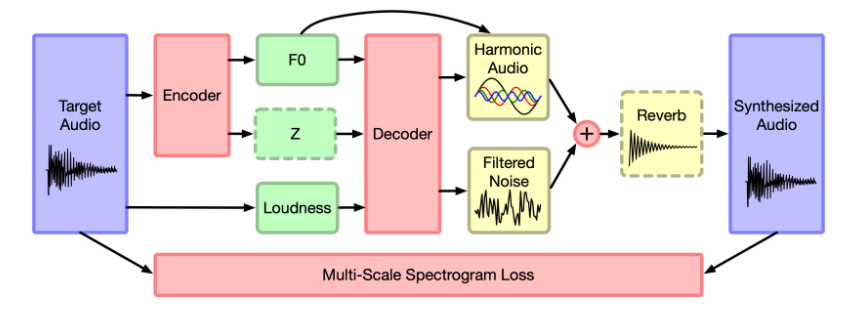

<img src="https://magenta.tensorflow.org/assets/ddsp/ddsp_cat_jamming.png" alt="DDSP Tone Transfer" width="700">

# Differentiable Additive Synthesizer

El sintetizador por suma genera los nuevos audios como una suma de las múltiples armonías de la frecuencia fundamental.
La red neuronal alimenta al sintetizador con los parámetros (frecuencia fundamental, amplitud, distribución de la armonía).

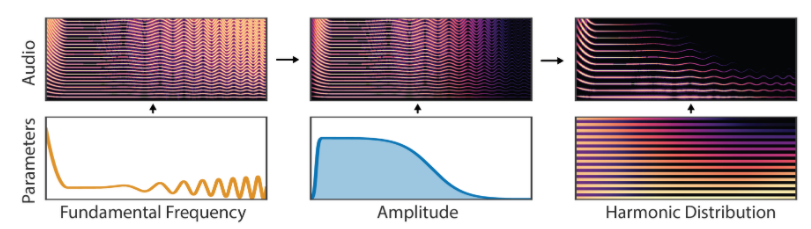


In [2]:
#@title #Instalacion e importación de dependencias

#@markdown Instalamos ddsp, definimos funciones de ayuda y descargamos los modelos. 
#@markdown Esto puede tardar un poco por la cantidad de informacion

!pip install -q note_seq

%tensorflow_version 2.x
print('Installing from pip package...')
!pip install -qU ddsp

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab import colab_utils
from ddsp.colab.colab_utils import (
    auto_tune, detect_notes, fit_quantile_transform, 
    get_tuning_factor, download, play, record, 
    specplot, upload, DEFAULT_SAMPLE_RATE)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Helper Functions
sample_rate = DEFAULT_SAMPLE_RATE  # 16000



import base64
import io
import pickle

import ddsp
import ddsp.training
from IPython import display


import note_seq
import numpy as np
from scipy import stats
from scipy.io import wavfile
import tensorflow.compat.v2 as tf

from google.colab import files
from google.colab import output


def wav_data_to_samples_pydub(wav_data: bytes,
                              sample_rate: int,
                              remove_dc_bias: bool = False,
                              num_channels: int = None,
                              normalize_db: float = None):
  """Convert audio file data (in bytes) into a numpy array using Pydub.
  Args:
    wav_data: A byte stream of audio data.
    sample_rate: Resample recorded audio to this sample rate.
    remove_dc_bias: If true, will remove DC bias from audio.
    num_channels: If not specified, output shape will be based on the contents
      of wav_data. Otherwise, will force to be 1 or 2 channels.
    normalize_db: Normalize the audio to this many decibels. Set to None to skip
      normalization step.
  Returns:
    An array of the recorded audio at sample_rate. If mono, will be shape
    [samples], otherwise [channels, samples].
  """
  # Parse and normalize the audio.
  aseg = pydub.AudioSegment.from_file(io.BytesIO(wav_data))
  if num_channels:
    aseg = aseg.set_channels(num_channels)
  if remove_dc_bias:
    aseg = aseg.remove_dc_offset()
  if normalize_db is not None:
    aseg.normalize(headroom=normalize_db)
  aseg = aseg.set_frame_rate(sample_rate)

  # Convert to numpy array.
  channel_asegs = aseg.split_to_mono()
  samples = [s.get_array_of_samples() for s in channel_asegs]
  fp_arr = np.array(samples).astype(np.float32)
  fp_arr /= np.iinfo(samples[0].typecode).max

  # If only 1 channel, remove extra dim.
  if fp_arr.shape[0] == 1:
    fp_arr = fp_arr[0]

  return fp_arr

def audio_bytes_to_np(wav_data,
                      sample_rate=DEFAULT_SAMPLE_RATE,
                      normalize_db=0.1):
  """Convert audio file data (in bytes) into a numpy array using Pydub.
  Args:
    wav_data: A byte stream of audio data.
    sample_rate: Resample recorded audio to this sample rate.
    normalize_db: Normalize the audio to this many decibels. Set to None to skip
      normalization step.
  Returns:
    An array of the recorded audio at sample_rate.
  """
  return wav_data_to_samples_pydub(
      wav_data=wav_data, sample_rate=sample_rate, normalize_db=normalize_db)

import pydub 

print('Done!')

     |████████████████████████████████| 215kB 4.7MB/s 
     |████████████████████████████████| 5.6MB 6.1MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
Installing from pip package...
     |████████████████████████████████| 153kB 4.8MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
     |████████████████████████████████| 3.6MB 14.9MB/s 
     |████████████████████████████████| 368kB 33.9MB/s 
Done!


#Modular Decomposition of Audio

En este ejemplo, se ha entrenado el decodificador del DDSP en un dataset con sonidos de violines, resintetizando el audio con el volumen y extrayendo la frecuencia fundamental del audio original.

Primero, se puede ver como la parte resyntetizada es realista y de hecho bastante similar a la del audio original.



Extracting audio features...


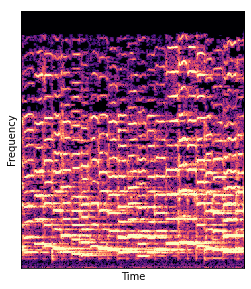

In [3]:
#@markdown Original Audio

audios_original_bytes = open("/content/FeatureFest/Timbre_Transfer/violin_original.mp3",'rb')

audios_original_read = audios_original_bytes.read()

audios_original = [(audio_bytes_to_np(audios_original_read,
                                   sample_rate=sample_rate,
                                   normalize_db=None))]

audio_original = audios_original[0]
audio_original = audio_original[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio_original)
play(audio_original)


Extracting audio features...


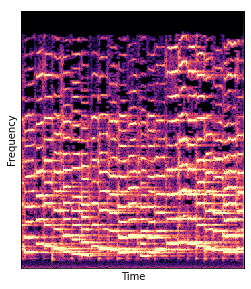

In [ ]:
#@markdown Resynthesis Audio 

audios_resynthesis_bytes = open("/content/FeatureFest/Timbre_Transfer/violin_resynthesis.mp3",'rb')

audios_resynthesis_read = audios_resynthesis_bytes.read()

audios_resynthesis = [(audio_bytes_to_np(audios_resynthesis_read,
                                   sample_rate=sample_rate,
                                   normalize_db=None))]

audio_resynthesis = audios_resynthesis[0]
audio_resynthesis = audio_resynthesis[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio_resynthesis)
play(audio_resynthesis)

El decodificador se utiliza para alimentar al sintetizador de suma de las señales y a un sintetizador que filtra el sonido, antes de pasarlo por el módulo del reverb.
Como el modelo está compuesto por una serie de módulos fácilmente interpretables, podemos examinar la salida de audio de cada uno de los módulos, para encontrar la descomposición modular de la señal de audio original.


Extracting audio features...


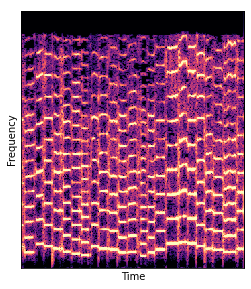

In [ ]:
#@markdown Reverb Removed 

audios_reverb_bytes = open("/content/FeatureFest/Timbre_Transfer/violin_no_reverb.mp3",'rb')

audios_reverb_read = audios_reverb_bytes.read()

audios_reverb = [(audio_bytes_to_np(audios_reverb_read,
                                   sample_rate=sample_rate,
                                   normalize_db=None))]

audio_reverb = audios_reverb[0]
audio_reverb = audio_reverb[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio_reverb)
play(audio_reverb)


Extracting audio features...


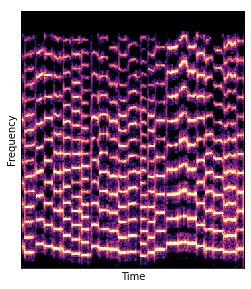

In [ ]:
#@markdown Additive Synth

audios_add_synth_bytes = open("/content/FeatureFest/Timbre_Transfer/violin_additive.mp3",'rb')

audios_add_synth_read = audios_add_synth_bytes.read()

audios_add_synth = [(audio_bytes_to_np(audios_add_synth_read,
                                   sample_rate=sample_rate,
                                   normalize_db=None))]
audio_add_synth = audios_add_synth[0]
audio_add_synth = audio_add_synth[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio_add_synth)
play(audio_add_synth)


Extracting audio features...


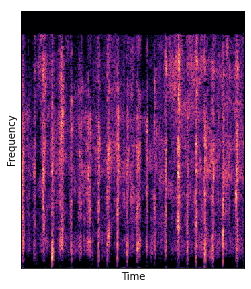

In [ ]:
#@markdown Filtered Noise Synth

audios_filt_nooise_bytes = open("/content/FeatureFest/Timbre_Transfer/violin_noise.mp3",'rb')

audios_filt_nooise_read = audios_filt_nooise_bytes.read()

audios_filt_nooise = [(audio_bytes_to_np(audios_filt_nooise_read,
                                   sample_rate=sample_rate,
                                   normalize_db=None))]
audio_filt_nooise = audios_filt_nooise[0]
audio_filt_nooise = audio_filt_nooise[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio_filt_nooise)
play(audio_filt_nooise)

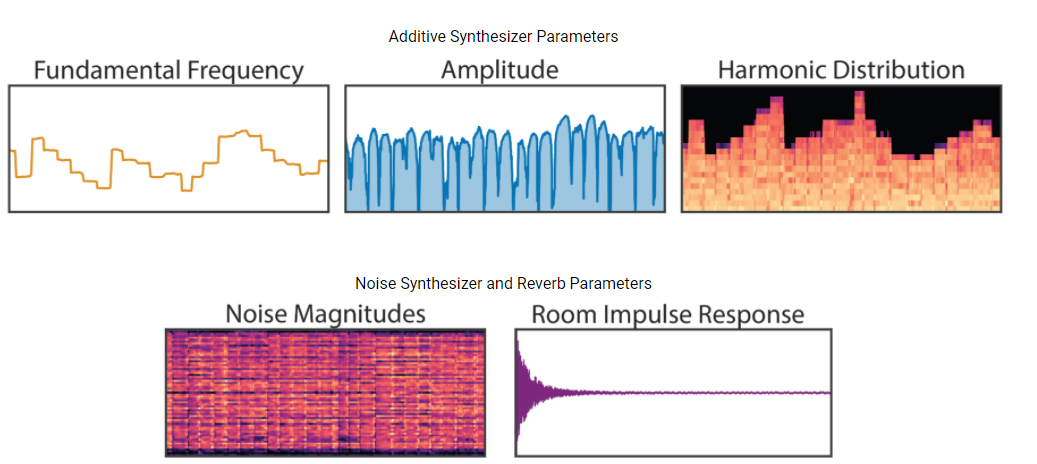

# DDSP Timbre Transfer

Ahora, vamos a usar el timbre transfer. Como hemos visto, podemos extraer los parámetros de nuestro audio para pasárselo al resintetizador. Si el decodificador lo hemos entrenado con un instrumento específico, ahora nuestro audio sonará como ese instrumento.

Para estos casos usaremos modelos ya preentrenados.

Puedes entrenar tu propio modelo con tus propios sonidos usando [Train Autoencoder Colab](https://github.com/magenta/ddsp/blob/master/ddsp/colab/demos/train_autoencoder.ipynb).







Extracting audio features...


Audio features took 14.0 seconds


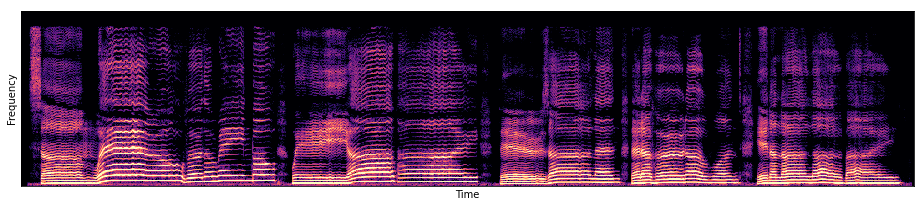

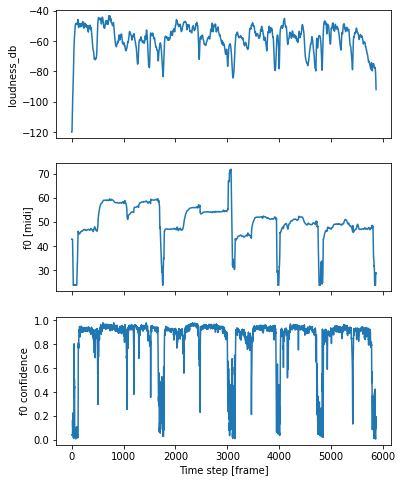

In [ ]:
#@title Subir o cargar un audio
#@markdown * Subir un fichero de audio (.mp3 or .wav) 
#@markdown * Este fichero debe ser monofónico (es decir, un sólo instrumento o voz)
#@markdown * Después se extraen las características de la frecuencia fundamental y del volumen del audio. 

#upload_file = "Upload (.mp3 or .wav)"  #@param ["Upload (.mp3 or .wav)"]


# Load audio sample here (.mp3 or .wav3 file)
# Just use the first file.

#filenames, audios = upload()

audios_bytes = open("/content/FeatureFest/Timbre_Transfer/singing.mp3",'rb')

audios_read = audios_bytes.read()

audios = [(audio_bytes_to_np(audios_read,
                                   sample_rate=sample_rate,
                                   normalize_db=None))]

audio = audios[0]
audio = audio[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio)
play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')



In [ ]:
#@title Cargamos el modelo
#@markdown Esto tendrá que ejecutarse cada vez que queramos crear una nueva salida de audio
model = 'Violin' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone', 'Upload your own (checkpoint folder as .zip)']
MODEL = model


def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir 


if model in ('Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone'):
  # Pretrained models.
  PRETRAINED_DIR = '/content/pretrained'
  # Copy over from gs:// for faster loading.
  !rm -r $PRETRAINED_DIR &> /dev/null
  !mkdir $PRETRAINED_DIR &> /dev/null
  GCS_CKPT_DIR = 'gs://ddsp/models/tf2'
  model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())
  
  !gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
  model_dir = PRETRAINED_DIR
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

else:
  # User models.
  UPLOAD_DIR = '/content/uploaded'
  !mkdir $UPLOAD_DIR
  uploaded_files = files.upload()

  for fnames in uploaded_files.keys():
    print("Unzipping... {}".format(fnames))
    !unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null
  model_dir = find_model_dir(UPLOAD_DIR)
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')


# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Additive.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Additive.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'DefaultPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Loading dataset statistics from /content/pretrained/dataset_statistics.pkl
Restoring model took 1.8 seconds


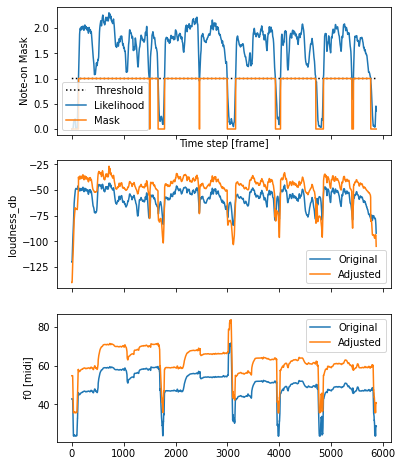

In [ ]:
#@title Modificando las condiciones

#@markdown A veces las salidas de los audios tras realizar la transferencia de timbre pueden sonar poco naturales si el volumen o la frecuencia de entrada son muy distintos de los de los datos de entrenamiento. Por lo tanto, aquí puedes modificar alguno de estos parámetros para poder ajustarlos y que el sonido de salida mejore. 


#@markdown ## Deteccion de notas

#@markdown Se puede dejar a 1 en la mayoría de los casos
threshold = 1 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Detectar partes silenciosas sin notas (dB)
quiet = 20 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Forzar a que se acerque a la nota más cercana (cantidad)
autotune = 0 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Cambiar la octava (octavas)
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Ajustar el volumen (dB)
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = DATASET_STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = colab_utils.fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=DATASET_STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)
    
    audio_features_mod['loudness_db'] = loudness_norm 

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2 
fig, axes = plt.subplots(nrows=n_plots, 
                      ncols=1, 
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])


Prediction took 1.1 seconds
Original


Resynthesis


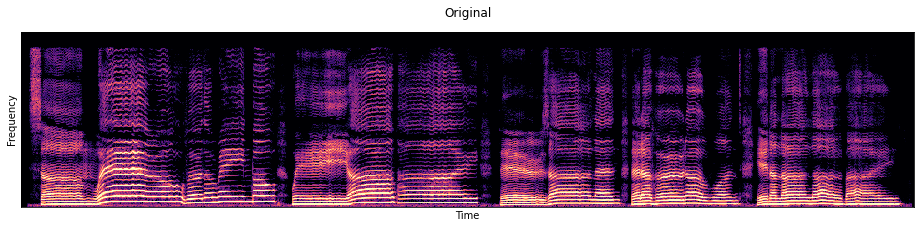

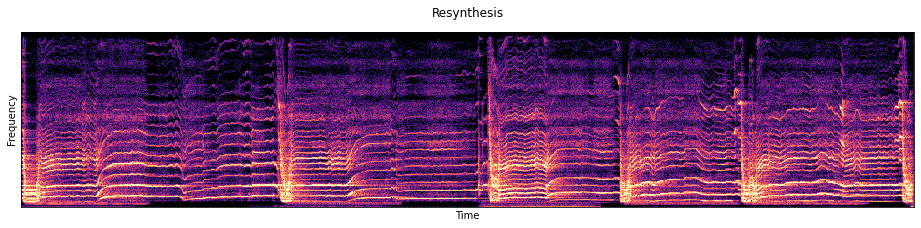

In [ ]:
#@title #Resintetizamos el Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
print('Prediction took %.1f seconds' % (time.time() - start_time))

# Plot
print('Original')
play(audio)

print('Resynthesis')
play(audio_gen)

specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")